Loading required package: Matrix



This is rSPDE 2.5.1
- See https://davidbolin.github.io/rSPDE for vignettes and manuals.

This is INLA_25.06.07 built 2025-06-11 18:54:45 UTC.
 - See www.r-inla.org/contact-us for how to get help.
 - List available models/likelihoods/etc with inla.list.models()
 - Use inla.doc(<NAME>) to access documentation

Loading required package: sp


Spatial Point Pattern Analysis Code in S-Plus
 
 Version 2 - Spatial and Space-Time analysis


Loading required package: viridisLite



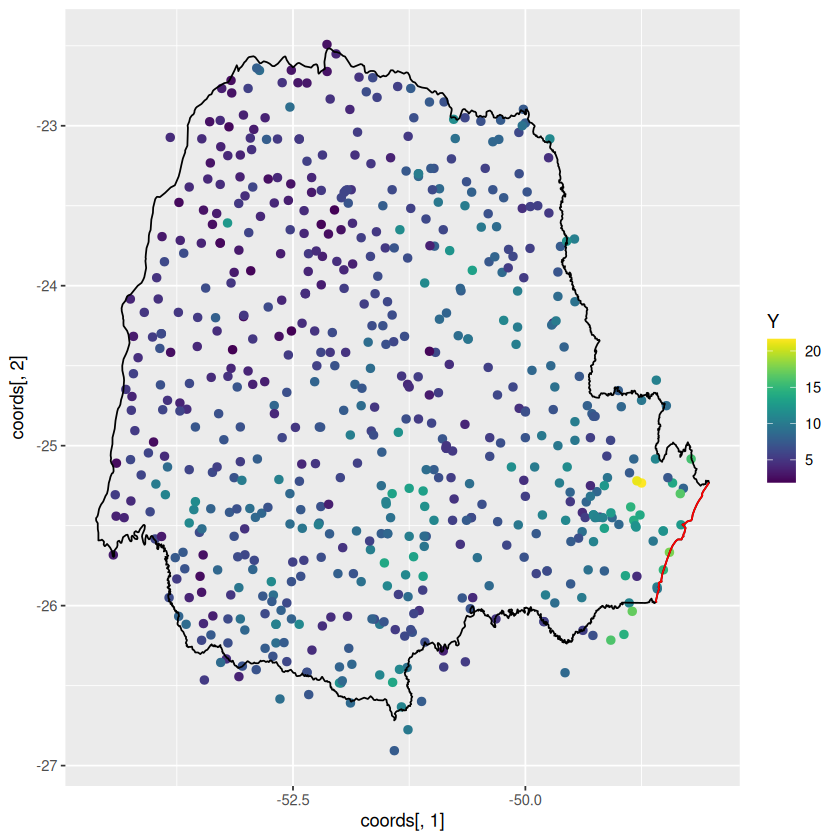

In [1]:
library(rSPDE)
library(ggplot2)
library(INLA)
library(splancs)
library(viridis)

#Load the data
data(PRprec)
data(PRborder)

#Get the precipitation in January
Y <- rowMeans(PRprec[, 3 + 1:31])

#Treat the data and plot
ind <- !is.na(Y)
Y <- Y[ind]
coords <- as.matrix(PRprec[ind, 1:2])
alt <- PRprec$Altitude[ind]

ggplot() +
  geom_point(aes(
    x = coords[, 1], y = coords[, 2],
    colour = Y
  ), size = 2, alpha = 1) +
  geom_path(aes(x = PRborder[, 1], y = PRborder[, 2])) +
  geom_path(aes(x = PRborder[1034:1078, 1], y = PRborder[
    1034:1078,
    2
  ]), colour = "red") + 
  scale_color_viridis()

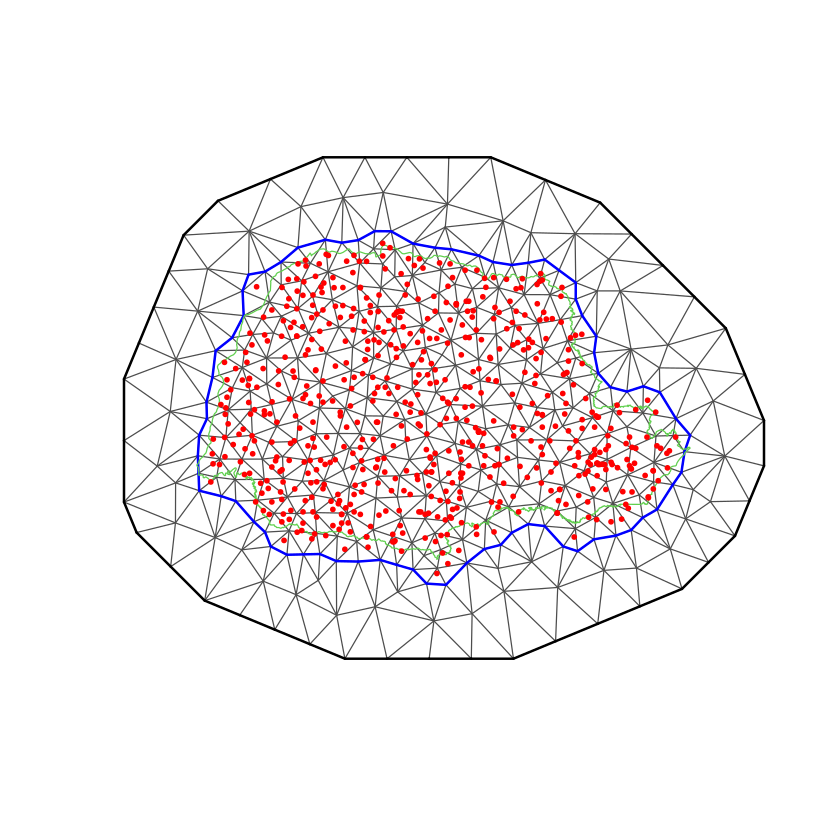

In [2]:
#Get distance from the sea
seaDist <- apply(spDists(coords, PRborder[1034:1078, ], longlat = TRUE), 1, 
                 min)
                 
#Create the mesh
library(fmesher)
prdomain <- fm_nonconvex_hull(coords, -0.03, -0.05, resolution = c(100, 100))
prmesh <- fm_mesh_2d(boundary = prdomain, max.edge = c(0.45, 1), cutoff = 0.2)
plot(prmesh, asp = 1, main = "")
lines(PRborder, col = 3)
points(coords[, 1], coords[, 2], pch = 19, cex = 0.5, col = "red")

In [3]:
#Create the observation matrix
Abar <- rspde.make.A(mesh = prmesh, loc = coords)

#Create the rspde model object
rspde_model <- rspde.matern(mesh = prmesh)

#Create the index and inla.stack object
mesh.index <- rspde.make.index(name = "field", mesh = prmesh)
stk.dat <- inla.stack(
  data = list(y = Y), A = list(Abar, 1), tag = "est",
  effects = list(
    c(
      mesh.index
    ),
    list(
      seaDist = inla.group(seaDist),
      Intercept = 1
    )
  )
)
                      
#Create the formula object and fit the model
f.s <- y ~ -1 + Intercept + f(seaDist, model = "rw1") +
  f(field, model = rspde_model)
  
rspde_fit <- inla(f.s, family = "Gamma", data = inla.stack.data(stk.dat), 
            verbose = FALSE, 
            control.inla=list(int.strategy='eb'),
            control.predictor = list(A = inla.stack.A(stk.dat), compute = TRUE))
            
summary(rspde_fit)

Time used:
    Pre = 0.544, Running = 1.95, Post = 0.026, Total = 2.52 
Fixed effects:
           mean    sd 0.025quant 0.5quant 0.975quant  mode kld
Intercept 1.941 0.042       1.86    1.941      2.023 1.941   0

Random effects:
  Name	  Model
    seaDist RW1 model
   field CGeneric

Model hyperparameters:
                                                  mean       sd 0.025quant
Precision-parameter for the Gamma observations   14.43    1.041     12.484
Precision for seaDist                          7545.26 4294.690   2315.136
Theta1 for field                                 -2.91    2.669     -9.011
Theta2 for field                                  1.86    0.712      0.717
Theta3 for field                                  1.33    2.341     -2.296
                                               0.5quant 0.975quant     mode
Precision-parameter for the Gamma observations    14.40      16.58   14.332
Precision for seaDist                           6556.30   18611.46 4953.163
Theta1 for fi

In [4]:
result_fit <- rspde.result(rspde_fit, "field", rspde_model)

Warning message in rspde.result(rspde_fit, "field", rspde_model):
“the mean or mode of nu is very close to nu.upper.bound, please consider increasing nu.upper.bound, and refitting the model.”
